# Reducing Down(stream)time: Pretraining Molecular GNNs using Heterogeneous AI Accelerators
* Notebook for plotting the results of Data Space Transfer and Potential Energy Surface Transfer downstream tasks
* Cached results must first be downloaded from https://data.pnnl.gov/group/nodes/dataset/33283 and untared

In [ ]:
"""
Notice: This computer software was prepared by Battelle Memorial Institute, hereinafter the Contractor,
under Contract No. DE-AC05-76RL01830 with the Department of Energy (DOE).  All rights in the computer software
are reserved by DOE on behalf of the United States Government and the Contractor as provided in the Contract.
You are authorized to use this computer software for Governmental purposes but it is not to be released or
distributed to the public.  NEITHER THE GOVERNMENT NOR THE CONTRACTOR MAKES ANY WARRANTY, EXPRESS OR IMPLIED,
OR ASSUMES ANY LIABILITY FOR THE USE OF THIS SOFTWARE.  This notice including this sentence must appear on any
copies of this computer software.
"""

In [1]:
import os.path as op
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Data Space Transfer

In [125]:
df_ipu = pd.read_csv('./results/nnp_cached/TTM_minima-min_and_nonmin.csv')
df_ipu['model_cat']=1
df_finetune = pd.read_csv('./results/nnp_cached/TTM_nonminima-min_and_nonmin.csv')
df_finetune['model_cat']=0
df_scratch = pd.read_csv('./results/nnp_cached/TTM_nonminima-min_and_nonmin-from_scratch.csv')
df_scratch['model_cat']=2
dfplot = pd.concat([df_ipu, df_finetune, df_scratch], sort=False, ignore_index=True)

In [127]:
sns.set_style("ticks")
sns.set_context("notebook", rc={"lines.linewidth": 3, 'lines.markersize': 10.0})
dfplot['e_actual_by_water_int']=round(dfplot['e_actual_by_water'])
dfplot['e_pred_by_water_int']=round(dfplot['e_pred_by_water'])
dfplot.sort_values(['model_cat','dataset'], inplace=True)

sns.set_palette(sns.color_palette("Paired")[2:4]+sns.color_palette("Paired")[6:8]+sns.color_palette("Paired")[:2])

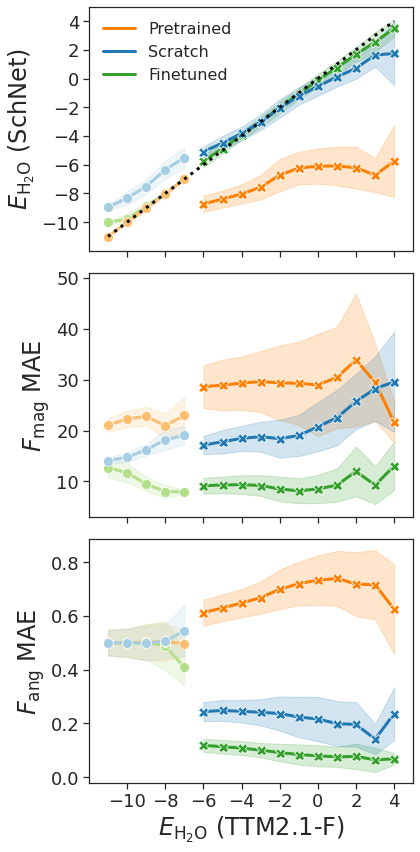

In [129]:
fig,(ax, ax1,ax2) = plt.subplots(3,1, figsize=(6,12), sharex=True)

l=sns.lineplot(data=dfplot, 
             x='e_actual_by_water_int', y='e_pred_by_water_int', 
             ci='sd', err_style="band", legend=True,
             hue=dfplot[['model_cat', 'dataset']].apply(tuple, axis=1) ,
             style='dataset', 
             markers=True, dashes=False, sizes='e_actual_by_water_int', ax=ax
             )
ax.plot([dfplot['e_actual_by_water_int'].min(),
         dfplot['e_actual_by_water_int'].max()],
         [dfplot['e_actual_by_water_int'].min(),
          dfplot['e_actual_by_water_int'].max()], ':', color='black')



ax.set_ylim(-12,5)
ax.set_yticks(np.arange(-10, 5, step=2))

sns.lineplot(data=dfplot, 
             x='e_actual_by_water_int', y='fme_mae', legend=False,
             ci='sd', err_style="band",
             hue=dfplot[['model_cat', 'dataset']].apply(tuple, axis=1) ,
             style='dataset',
             markers=True, dashes=False, sizes='e_actual_by_water_int', ax=ax1
             )


ax1.set_ylim(3,51)


sns.lineplot(data=dfplot, 
             x='e_actual_by_water_int', y='fae_mae',  legend=False,
             ci='sd', err_style="band",
             hue=dfplot[['model_cat', 'dataset']].apply(tuple, axis=1) ,
             style='dataset',
             markers=True, dashes=False, sizes='e_actual_by_water_int', ax=ax2
             )

plt.xlim(-12,5)
plt.xticks(np.arange(-10, 5, step=2))




for a in [ax, ax1, ax2]:
    a.tick_params(axis='both', which='major', labelsize=18)


ax.set_ylabel('$E_{\mathrm{H_2O}}$ (SchNet)', fontsize=24)
ax2.set_xlabel('$E_{\mathrm{H_2O}}$ (TTM2.1-F)', fontsize=24)

ax1.set_ylabel('$\mathit{F}_{\mathrm{mag}}$ MAE', fontsize=24)
ax2.set_ylabel('$\mathit{F}_{\mathrm{ang}}$ MAE', fontsize=24)


order = [1,2,0]
lines = l.lines[7::2]
labels=['Finetuned','Pretrained','Scratch']
ax.legend(handles=[lines[idx] for idx in order],
          labels=[labels[idx] for idx in order],
          frameon=False, fontsize=16) 

plt.tight_layout()
plt.savefig('NeurIPS_ML4PS_finetune_static.png', dpi=300)
plt.show()

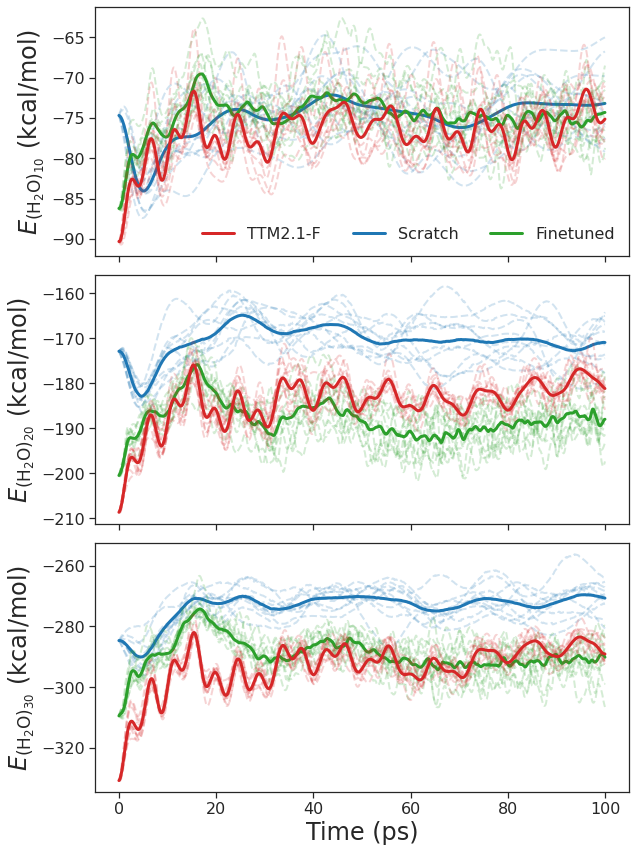

In [130]:
n_runs = 10
skip_ipu = True

# static params
n=42
base = './results/md_runs/'
step = 0.1

# converstion from eV to kcal/mol
conv = 23.0609
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
          '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


fig,axes = plt.subplots(3,1, figsize=(9,12), sharex=True)
for a,cluster_size in enumerate([10,20,30]):
    ax = axes[a]
    lines=[]
    for i,tag in enumerate(['scratch-nonmin_only', 'ipu', 'finetune-nonmin_only', 'ttm']):
        if tag == 'ipu' and skip_ipu:
            continue
        color = colors[i]
        for seed in range(1,n_runs+1):
            traj_file = op.join(base, f'W{cluster_size}_row{n}_{tag}_{seed}.traj')
            traj = Trajectory(traj_file)

            if seed == 1:
                energy=[atoms.get_potential_energy() for atoms in traj]
                energy=np.array(energy)*conv
            else:
                tmp=[atoms.get_potential_energy() for atoms in traj]
                tmp=np.array(tmp)*conv
                energy = np.vstack((energy, tmp))

        # get mean of all runs
        std = np.std(energy, axis=0)
        energy_mean = np.mean(energy, axis=0)

        # convert timesteps to ps 
        x = np.arange(0,len(energy_mean), step=1)*step

        # plot each run separately 
        for e in energy:
            ax.plot(x, e, "--", linewidth=2, label='__nolabel__', alpha=0.2, color=color)

        # plot means
        l=ax.plot(x, energy_mean, label=tag, color=color)
        lines+=l
        

    if skip_ipu:
        order = [2,0,1]
        labels = ['Scratch','Finetuned', 'TTM2.1-F']
        flag='noipu'
    else:   
        order = [3,1,2,0]
        labels = ['$\mathrm{GPU_{MD}~(pretrain)}$', '$\mathrm{IPU_{minima}}$', 
                  '$\mathrm{GPU_{MD}}$', 'TTM2.1-F']
        flag='ipu'

    ax.tick_params(axis='both', which='major', labelsize=16)
    if a==0:
        ax.legend(handles=[lines[idx] for idx in order],
                   labels=[labels[idx] for idx in order],
                   frameon=False,fontsize=16, ncol=3)


        
axes[0].set_ylabel('$E_{\mathrm{(H_2O)_{10}}}$ (kcal/mol)',fontsize=24)
axes[1].set_ylabel('$E_{\mathrm{(H_2O)_{20}}}$ (kcal/mol)',fontsize=24)
axes[2].set_ylabel('$E_{\mathrm{(H_2O)_{30}}}$ (kcal/mol)',fontsize=24)
plt.xlabel('Time (ps)',fontsize=24)

plt.tight_layout()
plt.savefig(f'NeurIPS-ML4PS-MD-W102030-{flag}.png', dpi=100)
plt.show()

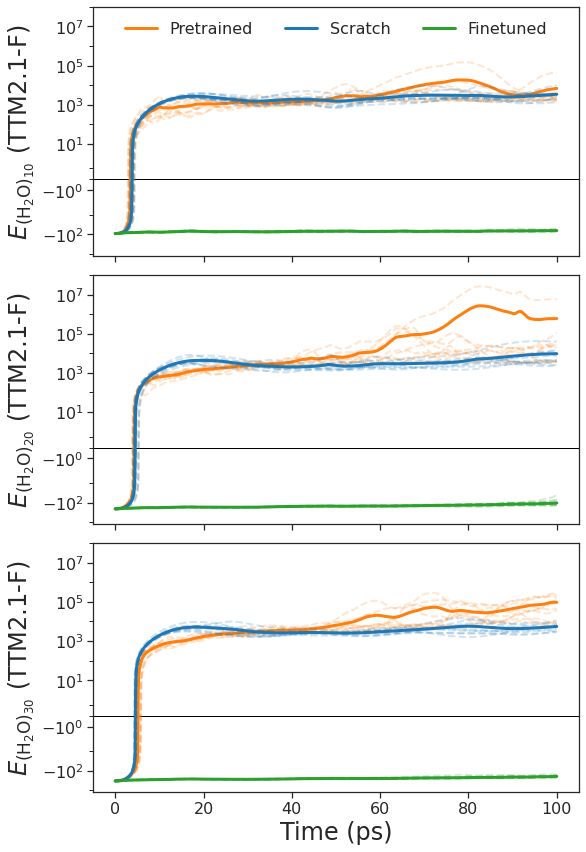

In [131]:
## NNP trajectories -- TTM predictions

tag='allNNPMD_ttmE'
n=42

colors = ['#ff7f0e','#1f77b4', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
          '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
labels = ['Pretrained', 'Scratch', 'Finetuned', ]

fig,axes = plt.subplots(3,1, figsize=(8.3,12), sharex=True, sharey=True)
for a,cluster_size in enumerate([10,20,30]):
    ax = axes[a]
    lines=[]
    for i, key in enumerate(['ipu','scratch','finetune']): #'ipu','scratch','finetune'
        color=colors[i]
        for seed in range(1,11):
            ecomp = np.load(op.join(base, f'W{cluster_size}_row{n}_{tag}_{seed}.npz'))

            e = ecomp[key]

            if seed == 1:
                errors = e
            else:
                tmp = e
                errors = np.vstack([errors,tmp])

        errors_mean = np.mean(errors, axis=0)
        std = np.std(errors, axis=0)


        # plot each run separately 
        c=1
        for e in errors:
            ax.plot(x, e, "--", linewidth=2, alpha=0.2, label='__nolabel__',color=color) 
            #axes[2].plot(x, e, "--", linewidth=2, label=c, alpha=1,color=colors[c-1]) 
            c+=1
        #axes[2].legend()
            
        x = np.arange(0,len(errors_mean), step=1)*step
        l=ax.plot(x,errors_mean, label=key, color=color)
        lines+=l
        #ax.fill_between(x, errors_mean-std, errors_mean+std, alpha=0.25, color=color)

    ax.set_yscale('symlog')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.hlines(0, -100, 200, color='black', linestyles='solid', linewidth=1)
    if a==0:
        ax.legend(handles=lines,
                   labels=labels,
                   frameon=False,fontsize=16, ncol=3, loc='upper center')

    
plt.xlim(-5,105)
plt.yticks([-1000, -100, -10,  -1,1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000][1::2])    
axes[0].set_ylabel('$E_\mathrm{{(H_2O)_{10}}}$ (TTM2.1-F)',fontsize=24)
axes[1].set_ylabel('$E_\mathrm{{(H_2O)_{20}}}$ (TTM2.1-F)',fontsize=24)
axes[2].set_ylabel('$E_\mathrm{{(H_2O)_{30}}}$ (TTM2.1-F)',fontsize=24)
plt.xlabel('Time (ps)',fontsize=24)


plt.tight_layout()
plt.savefig('NeurIPS-ML4PS-NNPMD-ttmE.png', dpi=100)
plt.show()
    


### Potential Energy Surface Transfer

In [68]:
# TTM_minima model
df_ipu = pd.read_csv('./results/cached/TTM_minima-min_data.csv')
format_df(df_ipu)
df_ipu_mbpol = pd.read_csv('./results/cached/TTM_minima-mbpol_data.csv')
format_df(df_ipu_mbpol)

# MBPol_minima model trained from scratch
df_mbpol_scratch = pd.read_csv('./results/cached/MBPol_minima-mbpol_data-from_scratch.csv')
format_df(df_mbpol_scratch)
df_mbpol_scratch_min = pd.read_csv('./results/cached/MBPol_minima-min_data-from_scratch.csv')
format_df(df_mbpol_scratch_min)

# MBPol_minima model finetuned from TTM_minima model
df_mbpol_ft = pd.read_csv('./results/cached/MBPol_minima-mbpol_data-finetuned.csv')
format_df(df_mbpol_ft)
df_mbpol_ft_min = pd.read_csv('./results/cached/MBPol_minima-min_data-finetuned.csv')
format_df(df_mbpol_ft_min)

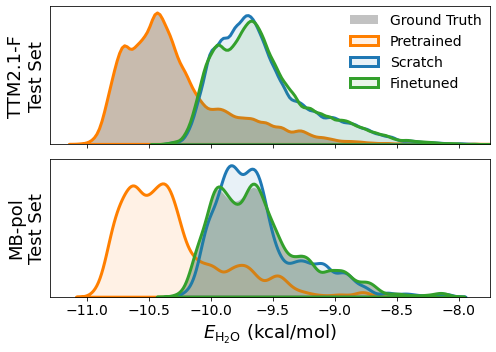

In [69]:
fig,(ax,ax1) = plt.subplots(2,1, figsize=(7,5), sharex=True)

# TTM test set

sns.kdeplot(data=df_ipu, x="e_actual_by_water", 
            shade=True, bw_adjust=0.5, ax=ax, label='Ground Truth', alpha=0.8,
           color=sns.color_palette("Set2")[-1],linewidth=0)

sns.kdeplot(data=df_ipu, x="e_pred_by_water", 
            shade=True, bw_adjust=0.5, ax=ax, alpha=0.1,
            label='Pretrained',
            color=sns.color_palette("Paired")[7],linewidth=3)

sns.kdeplot(data=df_mbpol_scratch_min, x="e_pred_by_water", 
            shade=True, bw_adjust=0.5, ax=ax, alpha=0.1,
            color=sns.color_palette("Paired")[1],label='Scratch',linewidth=3)

sns.kdeplot(data=df_mbpol_ft_min, x="e_pred_by_water", 
            shade=True, bw_adjust=0.5, ax=ax, alpha=0.1,
            color=sns.color_palette("Paired")[3],label='Finetuned',
            linewidth=3)

# MBpol test set

sns.kdeplot(data=df_ipu_mbpol, x="e_actual_by_water", 
            shade=True, bw_adjust=0.5, ax=ax1, alpha=0.8,
           color=sns.color_palette("Set2")[-1],linewidth=0)

sns.kdeplot(data=df_ipu_mbpol, x="e_pred_by_water", 
            shade=True, bw_adjust=0.5, ax=ax1, alpha=0.1,
            color=sns.color_palette("Paired")[7], linewidth=3)


sns.kdeplot(data=df_mbpol_scratch, x="e_pred_by_water", 
            shade=True, bw_adjust=0.5, ax=ax1, alpha=0.1,
            color=sns.color_palette("Paired")[1],linewidth=3)

sns.kdeplot(data=df_mbpol_ft, x="e_pred_by_water", 
            shade=True, bw_adjust=0.5, ax=ax1, alpha=0.1,
            color=sns.color_palette("Paired")[3], linewidth=3)

for a in [ax,ax1]:
    a.tick_params(axis='both', which='major', labelsize=14)
    a.set_yticks([])

ax.legend(frameon=False, fontsize=14, bbox_to_anchor=(1.01,1.04))
    
ax.set_ylabel('TTM2.1-F\nTest Set', fontsize=18)
ax1.set_ylabel('MB-pol\nTest Set', fontsize=18)
ax1.set_xlabel('$E_{\mathrm{H_2O}}$ (kcal/mol)', fontsize=18)

plt.xlim(-11.3,-7.75)
plt.xticks(np.arange(-11,-7.6, step=0.5))
plt.tight_layout()
plt.savefig('NeurIPS_ML4PS_transfer_energy.png', dpi=300)
plt.show()